In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import shapefile
from shapely.geometry import shape
import pandas as pd
from matplotlib.animation import FuncAnimation,  PillowWriter
import ast
from IPython.display import HTML 
from IPython.display import Image
import re

# Load and clean your data
df = pd.read_csv("/Users/adriennekirk/Desktop/Flash Droughts/Examples/Northeastern 4 week rolling.csv")

# Strip spaces and lowercase for clean matching
df['County'] = df['County'].str.lower().str.strip()
df['State'] = df['State'].str.lower().str.strip()

# Add combined key for matching
df['county_state'] = df['County'] + '_' + df['State']

statefp_to_abbr = {
    '09': 'ct', '23': 'me', '25': 'ma', '33': 'nh', '34': 'nj',
    '36': 'ny', '42': 'pa', '44': 'ri', '50': 'vt', '24': 'md',
    '54': 'wv', '10': 'de'
}

# Read shapefile
sf = shapefile.Reader("/Users/adriennekirk/Downloads/tl_2020_us_county/tl_2020_us_county.shp")
records = sf.shapeRecords()


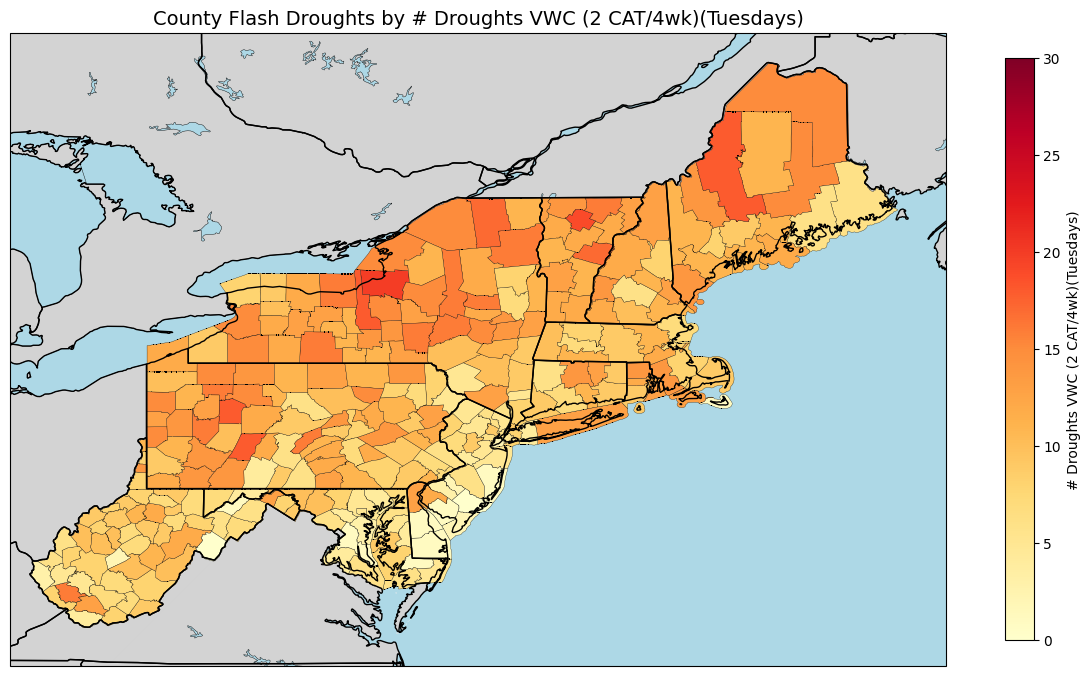

In [10]:
value_col = '# Droughts VWC (2 CAT/4wk)(Tuesdays)'

vmin = 0
vmax = 30
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('YlOrRd', 256)

fig, ax = plt.subplots(figsize=(12, 10),
                       subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-83, -66, 36.5, 48], crs=ccrs.PlateCarree())


for rec in records:
    attrs = rec.record.as_dict()
    county_name = attrs['NAME'].lower().strip()
    statefp = attrs['STATEFP']
    state_abbr = statefp_to_abbr.get(statefp, None)
    if not state_abbr:
        continue

    key = f"{county_name}_{state_abbr}"
    geom = shape(rec.shape.__geo_interface__)

    if key in df['county_state'].values:
        value = df.loc[df['county_state'] == key, value_col].values[0]
        color = cmap(norm(value))
    else:
        color = 'lightgrey'

    ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                      facecolor=color, edgecolor='black', linewidth=0.2)


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label=value_col, shrink=0.6)


ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=0)
ax.add_feature(cfeature.LAKES, facecolor='lightblue', edgecolor='black', linewidth=0.3, zorder=1)
ax.add_feature(cfeature.STATES, linewidth=1, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='none')

plt.title(f"County Flash Droughts by {value_col}", fontsize=14)
plt.tight_layout()
plt.show()

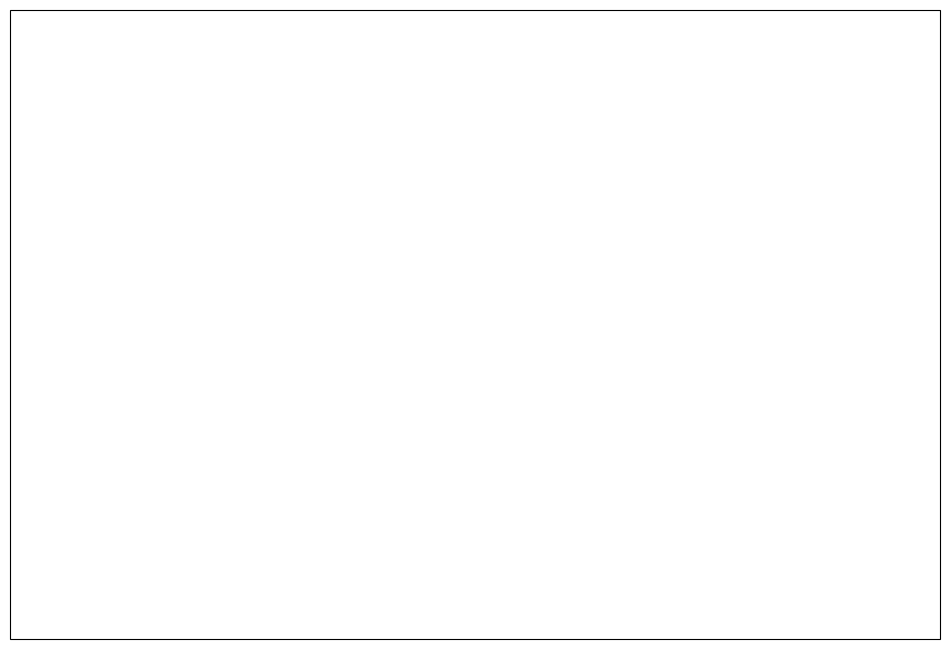

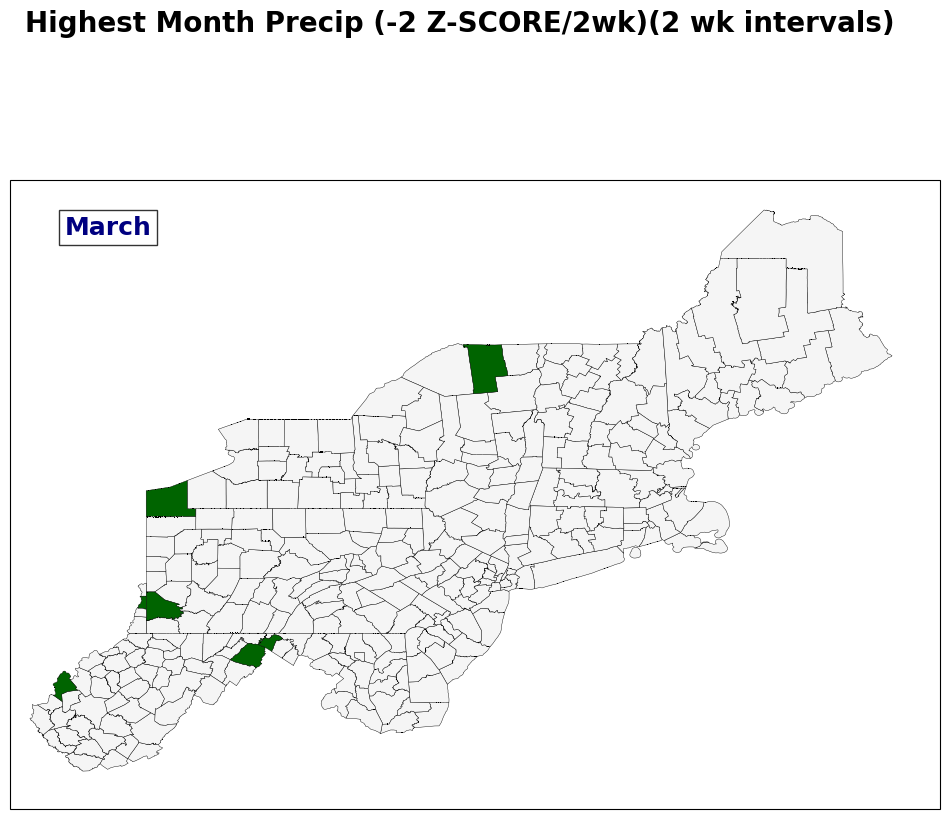

In [103]:



month_col = 'Highest Month Precip (-2 Z-SCORE/2wk)(2 wk intervals)'

def parse_month_list(x):
    if isinstance(x, str):
        try:
            return [m.strip().lower() for m in ast.literal_eval(x)]
        except Exception:
            return []
    elif isinstance(x, list):
        return [m.strip().lower() for m in x]
    else:
        return []

df['month_list'] = df[month_col].fillna("[]").apply(parse_month_list)

# Only animate these months
months = ['march', 'april', 'may', 'june', 'july', 'august', 'september', 'october']
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-83, -66, 36.5, 48], crs=ccrs.PlateCarree())
# Extract geometry + matching key
geoms = []
for rec in records:
    attrs = rec.record.as_dict()
    county_name = attrs['NAME'].lower().strip()
    statefp = attrs['STATEFP']
    state_abbr = statefp_to_abbr.get(statefp, None)
    if not state_abbr:
        continue
    key = f"{county_name}_{state_abbr}"
    geom = shape(rec.shape.__geo_interface__)
    geoms.append((key, geom))


# Month label
month_text = ax.text(-82, 47, "", fontsize=18, weight='bold', color='black',
                     bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
# month_text.set_text(month.capitalize())

# === Set up figure ===
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-83, -66, 36.5, 48], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=0)
ax.add_feature(cfeature.LAKES, facecolor='lightblue', edgecolor='black', linewidth=0.3, zorder=1)
ax.add_feature(cfeature.STATES, linewidth=1, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='none')


fig.suptitle(month_col, fontsize=20, weight='bold')

# Month label (top left)
month_text = ax.text(-82, 47, "", fontsize=18, weight='bold', color='navy',
                     bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

# === Update function ===
def update(frame):
    # Clear only geometries, not other features
    for coll in list(ax.collections):
        coll.remove()
    
    month = months[frame]
    month_text.set_text(month.capitalize())

    for key, geom in geoms:
        if key in df['county_state'].values:
            row = df.loc[df['county_state'] == key]
            month_list = row['month_list'].values[0]
            highlight = month.lower() in month_list
        else:
            highlight = False

        ax.add_geometries(
            [geom],
            crs=ccrs.PlateCarree(),
            facecolor='darkgreen' if highlight else 'whitesmoke',
            edgecolor='black',
            linewidth=0.3
        )

# === Animate ===
anim = FuncAnimation(fig, update, frames=len(months), interval=1000, repeat=True)
safe_name = re.sub(r'[^\w\-_.]', '_', month_col)  # replaces anything not alphanumeric, -, _, . with "_"

# Save using the sanitized name
anim.save(f"{safe_name}.mp4", writer="ffmpeg", fps=1)

# Save the animation
# gif_path = "/Users/adriennekirk/Desktop/flash_drought_months.gif"
# anim.save(gif_path, writer=PillowWriter(fps=1))

# print(f"GIF saved to: {gif_path}")
# Image(filename=gif_path)